## Correlation between NDSI and Fractional Snow Cover simulated via spectral mixture models 

An experiment to link observed (NDSI) and modeled quantities in fractional snow cover retrieval from satellite optical images

We consider a spectral mixture model:
- One pixel is composed by soil, snow, and vegetation in a variable fraction (endmembers).
- We consider different spectral mixing that express the total reflectance of that pixel as a combination of the endmembers reflectances

We perform a Montecarlo simulation of the NDSI for one pixel from different spectral mixture models. Each iteration can be summarized with these steps:
1. Pick a random snow fraction between 1% and 100%
2. Pick a random value of VIS and SWIR reflectances of the endmembers from some previously calibrated reflectance distributions 
3. Compute VIS and SWIR reflectances of the pixel using one of the spectral mixture models
4. Compute NDSI

We analyze the results NDSI vs FSC "classical" scatter plot from the NDSI - FSC pairs generated for each simulation

In other words, we simulate (simple) radiative forward models between FSC and NDSI. We compare these simulations to the retrieval  NDSI -> FSC approaches, formulated without assuming any forward model but fitting the observations.
This way we can:
- Have an idea of the uncertainty of NDSI based approaches, depending on the forward model chosen 
- The ability of the different models to capture real observations (NDSI - FSC scatter plots from the litterature)

### Calibration of endmembers reflectance distribution 


We use one VIIRS image from february to characterize bare soil, vegetation and snow endmembers (as seen from satellites). In practice we plot the reflectance histogram for these images for vegetation, bare soil and snow cover, and try to fit a normal distribution to the histogram. This will give us a mean and std to use for the Montecarlo simulation

In [1]:
# Defining Endmember objsects

from dataclasses import dataclass

@dataclass
class NormalDistributoinEndMember:
    mu: float
    sigma: float

@dataclass
class BandEM:
    forest: NormalDistributoinEndMember
    soil: NormalDistributoinEndMember
    snow: NormalDistributoinEndMember

In [2]:
# Read data

import xarray as xr
import rasterio
import numpy as np

# Region of interest on French mountains
roi_mask=rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/MSF_MASK_FRANCE_GEO_375m.tif')
roi_mask = np.where(roi_mask.read(1)==roi_mask.nodata, 0, roi_mask.read(1))
# CORINE forest mask
forest_mask = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/forest_mask/corine_2018/corine_2018_forest_mask_france_geo_375m.tif').read(1)*roi_mask
# Copernicus tree cover density
tree_cover_density = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/tree_cover_density/2018/tcd_france_geo_375m.tif').read(1)*roi_mask
# Red and SWIR band on a SWIR image
red_band = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/data/V02IMG/VNP02IMG_GEO_375m/VNP02IMG_GEO_375m.A2024044.1206.002.2024044204638.nc').data_vars['I01'].where(roi_mask)/np.cos(np.deg2rad(60))*100
swir_band = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/data/V02IMG/VNP02IMG_GEO_375m/VNP02IMG_GEO_375m.A2024044.1206.002.2024044204638.nc').data_vars['I03'].where(roi_mask)/np.cos(np.deg2rad(60))*100

# Fractional snow cover Météo-France product
snow_cover = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/SNPP/produit_synopsis/2024/02/20240213_120329_npp_produit_synopsis.tif').read(1)*roi_mask

In [3]:
# Pixels for red band endmember
red_veg = np.where(forest_mask * (snow_cover==0), red_band, np.nan).flatten()
red_soil = np.where((1-forest_mask) * (snow_cover==0), red_band, np.nan).flatten()
# We take 100% snow cover pixels to characterize snow cover endmemeber
red_snow = np.where((1-forest_mask) * (snow_cover==200), red_band, np.nan).flatten()

# Pixels for SWIR band endmembers
swir_veg = np.where(forest_mask * (snow_cover==0), swir_band, np.nan).flatten()
swir_soil = np.where((1-forest_mask) * (snow_cover==0), swir_band, np.nan).flatten()
# We take 100% snow cover pixels to characterize snow cover endmemeber
swir_snow = np.where((1-forest_mask) * (snow_cover==200), swir_band, np.nan).flatten()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Manual calibration of reflectance distributions to reflectance histogrammes using a plot
def calibrate_normal_distirbution_to_histogram(image: np.array, mu:float, sigma:float, n_points:int=10000,ax: Axes | None =None):
    if ax is None:
        fig, ax=plt.subplots()
    h = np.histogram(image,bins=np.arange(100,step=0.05))
    ax.plot(np.arange(100,step=0.05)[:-1],h[0]/np.max(h[0]),label="satellite")
    sim = np.random.normal(loc=mu, scale=sigma, size=(n_points,))
    h = np.histogram(sim,bins=np.arange(100,step=0.05))
    ax.plot(np.arange(100,step=0.05)[:-1],h[0]/np.max(h[0]),label="simulation")
    ax.legend()

# Modify here mean and std of simulation reflectances
# We iteratively modify until the simulated endmember distribution matches the observed one
red = BandEM(forest=NormalDistributoinEndMember(mu=7, sigma=1.5),soil=NormalDistributoinEndMember(mu=8,sigma=1.5), snow=NormalDistributoinEndMember(mu=60, sigma=30))
swir = BandEM(forest=NormalDistributoinEndMember(mu=16, sigma=5),soil=NormalDistributoinEndMember(mu=18,sigma=6), snow=NormalDistributoinEndMember(mu=6, sigma=5))

Text(0.5, 1.0, 'Red band snow')

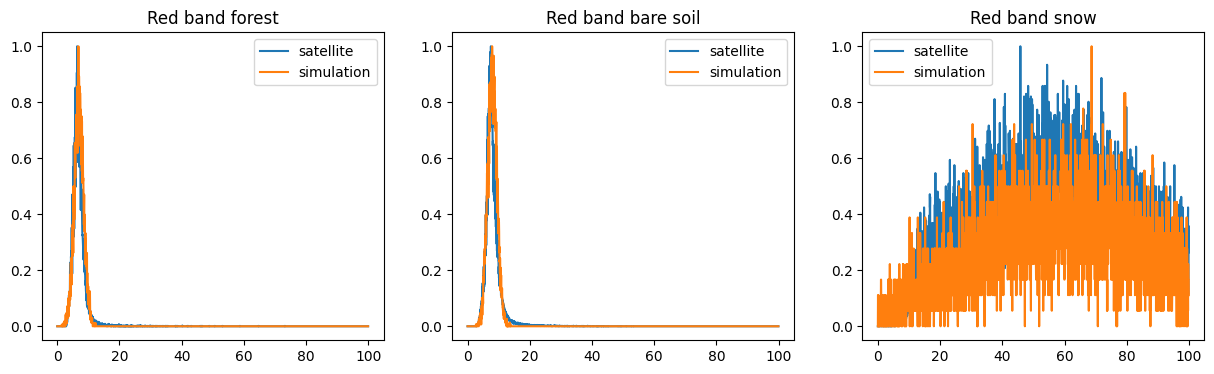

In [5]:
# Red band (simulated should match satellite)
fig, axs = plt.subplots(1,3,figsize=(15,4))
calibrate_normal_distirbution_to_histogram(image=red_veg, mu=red.forest.mu, sigma=red.forest.sigma, ax=axs[0])
axs[0].set_title("Red band forest")
calibrate_normal_distirbution_to_histogram(image=red_soil, mu=red.soil.mu, sigma=red.soil.sigma, ax=axs[1])
axs[1].set_title("Red band bare soil")
calibrate_normal_distirbution_to_histogram(image=red_snow, mu=red.snow.mu, sigma=red.snow.sigma, ax=axs[2])
axs[2].set_title("Red band snow")

Look at that chaotic red band reflectance distribution of snow pixels!

Text(0.5, 1.0, 'SWIR band snow')

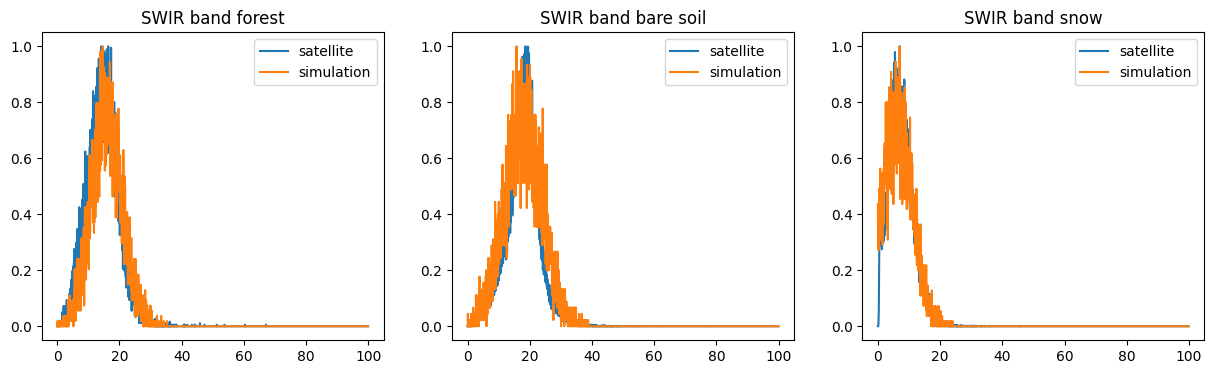

In [6]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
calibrate_normal_distirbution_to_histogram(image=swir_veg, mu=swir.forest.mu, sigma=swir.forest.sigma, ax=axs[0])
axs[0].set_title("SWIR band forest")
calibrate_normal_distirbution_to_histogram(image=swir_soil, mu=swir.soil.mu, sigma=swir.soil.sigma, ax=axs[1])
axs[1].set_title("SWIR band bare soil")
calibrate_normal_distirbution_to_histogram(image=swir_snow, mu=swir.snow.mu, sigma=swir.snow.sigma, ax=axs[2])
axs[2].set_title("SWIR band snow")


Define some spectral mixing models used in litterature

In [7]:
def compute_test_ndsi_scamod(rho_wet_snow_g: float=0.9, 
                             rho_wet_snow_swir: float=0, 
                             rho_veg_g:float=0.3, 
                             rho_veg_swir:float=0.3, 
                             rho_soil_g:float=0.3, 
                             rho_soil_swir:float=0.5,
                             t2_g: float=0.5,
                             t2_swir:float=0.5,
                             f_snow:float=0.5,
                             ):
    """SCAmod algorithm (Metsämäki et al. 2012).
    In use for VIIRS Northern emisphere CLMS.
    A transmittivity term t2 characterizes the scattering in the forest.
    This transmittivity term has to be estimated spatially.
    """
    # Generate snow fractions
    rho_g = rho_veg_g * (1-t2_g)  + t2_g*(f_snow*rho_wet_snow_g + (1-f_snow)*rho_soil_g)
    rho_swir = rho_veg_swir * (1-t2_swir)  + t2_swir*(f_snow*rho_wet_snow_swir + (1-f_snow)*rho_soil_swir)
    return (rho_g - rho_swir) / (rho_g + rho_swir)

def compute_test_ndsi_lin(f_veg: float, 
                          rho_snow_g: float=0.9, 
                          rho_snow_swir: float=0, 
                          rho_veg_g:float=0.3, 
                          rho_veg_swir:float=0.3, 
                          rho_soil_g:float=0.3, 
                          rho_soil_swir:float=0.5,
                          f_snow:float=0.5):
    """Linear mix model:
       Total reflectance as a linear combination of endmembers reflectances weighted by their fraction.
       See publications on MODSCAG (Painter et al. 2009)
    """
    # Generate snow fractions
    f_soil = 1 - f_veg - f_snow
    rho_g = rho_snow_g * f_snow + rho_veg_g * f_veg + rho_soil_g * f_soil
    rho_swir = rho_snow_swir * f_snow + rho_veg_swir * f_veg + rho_soil_swir * f_soil
    return (rho_g - rho_swir) / (rho_g + rho_swir)



In [8]:
def generate_landcover_simulation(red_band: BandEM, swir_band: BandEM, n_sim:int=10_000):
    """Generate random pixel red and SWIR using previously defined normal distirbution endmembers"""
    rho_snow_r = np.random.normal(loc=red_band.snow.mu, scale=red_band.snow.sigma, size=(n_sim,))
    rho_snow_swir = np.random.normal(loc=swir_band.snow.mu, scale=swir_band.snow.sigma, size=(n_sim,))
    rho_soil_r = np.random.normal(loc=red_band.soil.mu, scale=red_band.soil.sigma, size=(n_sim,))
    rho_soil_swir = np.random.normal(loc=swir_band.soil.mu, scale=swir_band.soil.sigma, size=(n_sim,))
    rho_veg_r = np.random.normal(loc=red_band.forest.mu, scale=red_band.forest.sigma, size=(n_sim,))
    rho_veg_swir = np.random.normal(loc=swir_band.forest.mu, scale=swir_band.forest.sigma, size=(n_sim,))
    return rho_soil_r,rho_veg_r,rho_snow_r,rho_soil_swir,rho_snow_swir,rho_veg_swir

## Montecarlo simulation of NDSI using a spectral mixture model

## No vegetation simulation

For no vegetation the two models are equivalent to the linear mixing model

In [9]:
import random

# Number of simulations
N=500_000

ndsi_linear = np.zeros(shape=(N,))
f_snow = np.zeros(shape=(N,))

snow_cover_only_positive_fractions = snow_cover[((snow_cover<200)*(snow_cover>0))] / 200
for idx, (test_rho_soil_r, test_rho_veg_r,test_rho_snow_r, test_rho_soil_swir, test_rho_snow_swir, test_rho_veg_swir) in enumerate(zip(*generate_landcover_simulation(red_band=red, swir_band=swir,n_sim=N))):
    
    fsc_random_sample = random.choice(snow_cover_only_positive_fractions) 
    # Limit the apparition of bands in the scvatter plot
    if fsc_random_sample>0.01 and fsc_random_sample<0.99:
        fsc_random_sample=fsc_random_sample+np.random.uniform(-0.01,0.01)
    f_snow[idx]=fsc_random_sample
    
    ndsi_linear[idx] = compute_test_ndsi_lin(f_veg=0,
                                            rho_soil_g=test_rho_soil_r,
                                            rho_soil_swir=test_rho_soil_swir,
                                            rho_snow_g=test_rho_snow_r,
                                            rho_snow_swir=test_rho_snow_swir,
                                            rho_veg_g=test_rho_veg_r,
                                            rho_veg_swir=test_rho_veg_swir,
                                            f_snow=fsc_random_sample)
    


Plot the results on a scatter plot and compare to a reference of VIIRS observation vs S2 FSC

In [10]:
# Define (Salomonson and Appel, 2006) and (Gascoin, 2020) NDSI to FSC regression

def salomonson_appel(ndsi):
    return 1.45*ndsi - 0.01

def gascoin(ndsi, f_veg):
    f_snow_toc = 0.5 * np.tanh(2.65*ndsi - 1.42) + 0.5
    return np.minimum(1, f_snow_toc/(1-f_veg))

<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\%'
<>:24: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_25154/1287687255.py:23: SyntaxWarning: invalid escape sequence '\%'
  xlabels = ["Simulated NDSI [%]", "VNP10A1 NDSI [\%]"]
/tmp/ipykernel_25154/1287687255.py:24: SyntaxWarning: invalid escape sequence '\%'
  ylabels = ["FSC", "S2 FSC [\%]"]


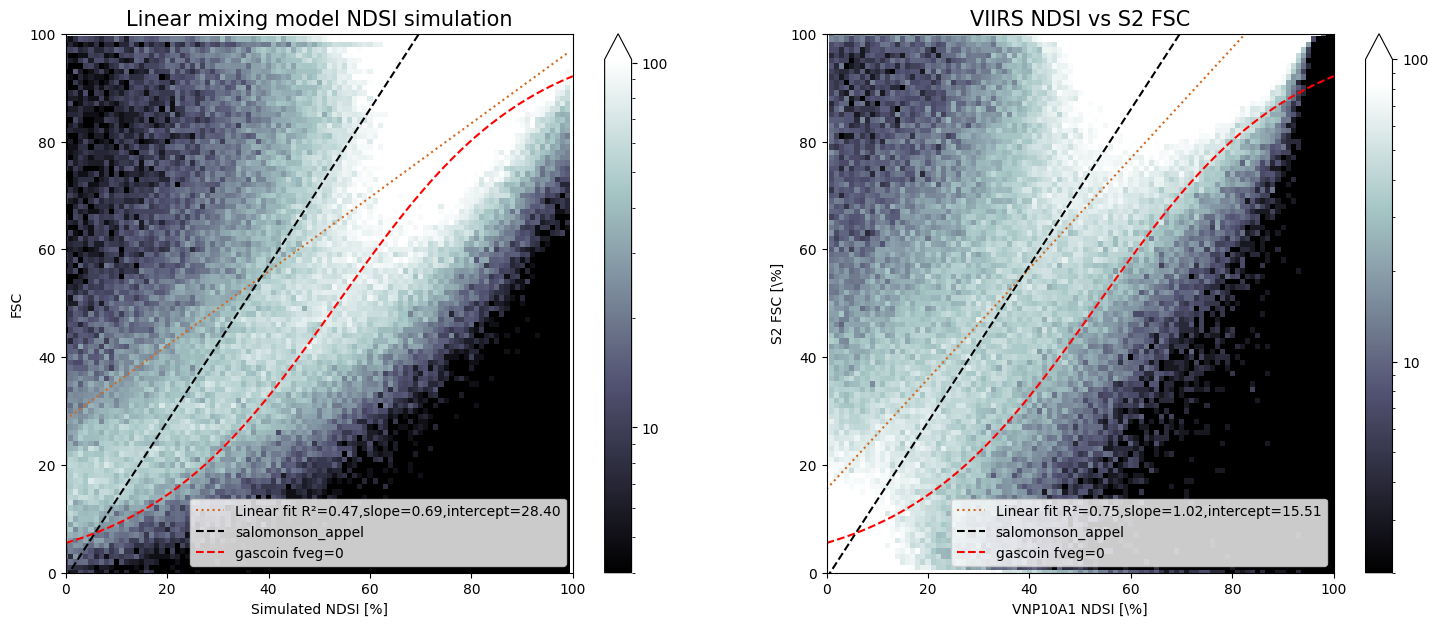

In [11]:
import xarray as xr

from postprocess.scatter_plot import fancy_scatter_plot

fig, ax = plt.subplots(1,2,figsize=(18,7))

# Generate Salomonson and Appel reference line 
ndsi_bins = np.linspace(0,1,1000)
fsc_salomonson = salomonson_appel(ndsi_bins)

# Generate Gascoin reference line 
fsc_gascoin = gascoin(ndsi_bins, f_veg=0)

hist = np.histogram2d(f_snow*100, ndsi_linear*100, bins=(np.arange(0,101),np.arange(0,101)))
simulated_scatter_plot = xr.DataArray(data=hist[0].T, coords={'x': hist[1][:-1], 'y':hist[2][:-1]})

# Scatter plot of VIIRS (NASA VNP10A1 product) NDSI vs Sentinel-2 FSC resampled at 375 m. Soon to be published
viirs_l3_scatter_plot_no_forest = xr.open_dataset(
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/scatter/scatter_WY_2023_2024_nasa_l3_snpp_vs_S2_theia.nc"
).data_vars['n_occurrences'].sel(ref_bins=slice(0,100),test_bins=slice(1,100),forest_mask_bins='no_forest').sum(('altitude_bins', 'time')).rename({"ref_bins": "y", "test_bins": "x"})

titles = ["Linear mixing model NDSI simulation", "VIIRS NDSI vs S2 FSC"]
xlabels = ["Simulated NDSI [%]", "VNP10A1 NDSI [\%]"]
ylabels = ["FSC", "S2 FSC [\%]"]
for idx, scatter_plot in enumerate([simulated_scatter_plot, viirs_l3_scatter_plot_no_forest]):

    fancy_scatter_plot(data_to_plt=scatter_plot, ax=ax[idx],figure=fig, smoothing_window_size=0)
    ax[idx].plot(ndsi_bins*100, fsc_salomonson*100, '--k',label='salomonson_appel')
    ax[idx].plot(ndsi_bins*100, fsc_gascoin*100, '--r',label='gascoin fveg=0')
    ax[idx].set_ylabel(ylabels[idx])
    ax[idx].set_xlabel(xlabels[idx])
    ax[idx].set_title(titles[idx], fontsize=15)
    ax[idx].set_ylim(0,100)
    ax[idx].set_xlim(0,100)
    ax[idx].legend()


## Forest simulation

In presence of trees we consider the three models

In [12]:
# Number of simulations
N=500_000

ndsi_linear = np.zeros(shape=(N,))
ndsi_scamod = np.zeros(shape=(N,))
f_snow = np.zeros(shape=(N,))

snow_cover_only_positive_fractions = snow_cover[((snow_cover<200)*(snow_cover>0))] / 200
tree_cover_density_forest_only = tree_cover_density[forest_mask.astype(bool)]
for idx, (test_rho_soil_g, test_rho_veg_g,test_rho_snow_g, test_rho_soil_swir, test_rho_snow_swir, test_rho_veg_swir) in enumerate(zip(*generate_landcover_simulation(red_band=red, swir_band=swir,n_sim=N))):
    
    
    fsc_random_sample = random.choice(snow_cover_only_positive_fractions) 
    # Limit bands on scatter plot
    if fsc_random_sample>0.01 and fsc_random_sample<0.99:
        fsc_random_sample=fsc_random_sample+np.random.uniform(-0.01,0.01)
    fveg = random.choice(tree_cover_density_forest_only) / 100
    
    f_snow[idx]=fsc_random_sample
    # Forest transmittivity of SCAmod brutally set to vegetation fraction
    ndsi_scamod[idx] = compute_test_ndsi_scamod(rho_soil_g=test_rho_soil_g,
                                                    rho_soil_swir=test_rho_soil_swir, 
                                                    rho_wet_snow_g=test_rho_snow_g, 
                                                    rho_wet_snow_swir=test_rho_snow_swir,
                                                    rho_veg_swir=test_rho_veg_swir,
                                                    rho_veg_g=test_rho_veg_g,
                                                    f_snow=fsc_random_sample,
                                                    t2_g=fveg,
                                                    t2_swir=fveg,
                                                    )
    
    # Vegetation fraction brutally set to TCD
    ndsi_linear[idx] = compute_test_ndsi_lin(f_veg=fveg,
                                            rho_soil_g=test_rho_soil_g,
                                            rho_soil_swir=test_rho_soil_swir,
                                            rho_snow_g=test_rho_snow_g,
                                            rho_snow_swir=test_rho_snow_swir,
                                            rho_veg_g=test_rho_veg_g,
                                            rho_veg_swir=test_rho_veg_swir,
                                            f_snow=fsc_random_sample)
    



<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
<>:25: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_25154/3769584379.py:25: SyntaxWarning: invalid escape sequence '\%'
  ylabels = ["FSC[\%]","FSC[\%]", "S2 FSC [\%]"]
/tmp/ipykernel_25154/3769584379.py:25: SyntaxWarning: invalid escape sequence '\%'
  ylabels = ["FSC[\%]","FSC[\%]", "S2 FSC [\%]"]
/tmp/ipykernel_25154/3769584379.py:25: SyntaxWarning: invalid escape sequence '\%'
  ylabels = ["FSC[\%]","FSC[\%]", "S2 FSC [\%]"]


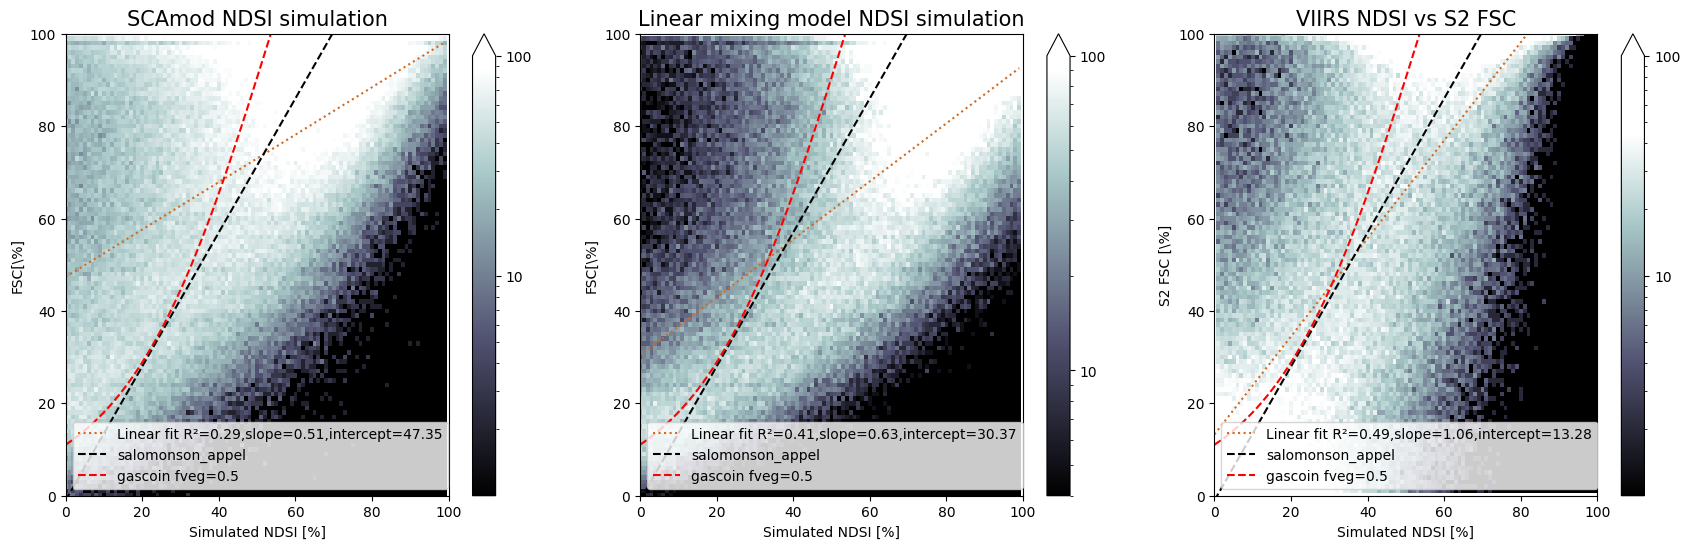

In [13]:
import xarray as xr

from postprocess.scatter_plot import fancy_scatter_plot

fig, ax = plt.subplots(1,3,figsize=(21,6))

# Generate Salomonson and Appel reference line 
ndsi_bins = np.linspace(0,1,1000)
fsc_salomonson = salomonson_appel(ndsi_bins)

# Generate Gascoin reference line 
fsc_gascoin = gascoin(ndsi_bins, f_veg=0.5)

hist = np.histogram2d(f_snow*100, ndsi_scamod*100, bins=(np.arange(0,101),np.arange(0,101)))
simulated_scatter_plot_scamod = xr.DataArray(data=hist[0].T, coords={'x': hist[1][:-1], 'y':hist[2][:-1]})
hist = np.histogram2d(f_snow*100, ndsi_linear*100, bins=(np.arange(0,101),np.arange(0,101)))
simulated_scatter_plot_linear = xr.DataArray(data=hist[0].T, coords={'x': hist[1][:-1], 'y':hist[2][:-1]})
# Scatter plot of VIIRS (NASA VNP10A1 product) NDSI vs Sentinel-2 FSC resampled at 375 m for forest. Soon to be published
viirs_l3_scatter_plot_forest = xr.open_dataset(
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_8/analyses/scatter/scatter_WY_2023_2024_nasa_l3_snpp_vs_S2_theia.nc"
).data_vars['n_occurrences'].sel(ref_bins=slice(1,100),test_bins=slice(1,100),forest_mask_bins='forest').sum(('altitude_bins', 'time')).rename({"ref_bins": "y", "test_bins": "x"})

titles = ["SCAmod NDSI simulation", "Linear mixing model NDSI simulation", "VIIRS NDSI vs S2 FSC"]
xlabels = ["Simulated NDSI [%]","Simulated NDSI [%]","Simulated NDSI [%]"] 
ylabels = ["FSC[\%]","FSC[\%]", "S2 FSC [\%]"]

for idx, scatter_plot in enumerate([simulated_scatter_plot_scamod, simulated_scatter_plot_linear, viirs_l3_scatter_plot_forest]):

    fancy_scatter_plot(data_to_plt=scatter_plot, ax=ax[idx],figure=fig, smoothing_window_size=0)
    ax[idx].plot(ndsi_bins*100, fsc_salomonson*100, '--k',label='salomonson_appel')
    ax[idx].plot(ndsi_bins*100, fsc_gascoin*100, '--r',label='gascoin fveg=0.5')
    ax[idx].set_ylabel(ylabels[idx])
    ax[idx].set_xlabel(xlabels[idx])
    ax[idx].set_title(titles[idx], fontsize=15)
    ax[idx].set_ylim(0,100)
    ax[idx].set_xlim(0,100)
    ax[idx].legend()




## Conclusions

Simulations and observations do not totally match. The observed correlation is pseudo-linear while the modeled one is curve, and the point distribution have notable differences. Nevertheless there might be some lessons to learn here:
- Observed and even simulated scatter plots present a large spread of the points. A NDSI value can be produced by a big range of FSC values. That's because the uncertainties linked to endmember reflectances are high enough to dominate over the linear mixing assumption when propagated via NDSI calculation. In other words, FSC and NDSI are only weakly correlated. For any function we might fit the residuals will be high.
- Linear mixing model struggles to represent NDSI observed distribution in the forest. There are a lot of points at high NDSI and 60-80% FSC that are pretty unrealistic. SCAmod behaves better in the forest (no surprise as it has been develop especially for this task). This would mean that spectral unmixing techniques are not well adapted to retrieve FSC in the forest

### References

[1] S. Metsämäki, O.-P. Mattila, J. Pulliainen, K. Niemi, K. Luojus, et K. Böttcher, « An optical reflectance model-based method for fractional snow cover mapping applicable to continental scale », Remote Sensing of Environment, vol. 123, p. 508‑521, août 2012, doi: 10.1016/j.rse.2012.04.010.

[2] T. H. Painter, K. Rittger, C. McKenzie, P. Slaughter, R. E. Davis, et J. Dozier, « Retrieval of subpixel snow covered area, grain size, and albedo from MODIS », Remote Sensing of Environment, vol. 113, nᵒ 4, p. 868‑879, avr. 2009, doi: 10.1016/j.rse.2009.01.001.

[3] S. Gascoin et al., « Estimating Fractional Snow Cover in Open Terrain from Sentinel-2 Using the Normalized Difference Snow Index », Remote Sensing, vol. 12, nᵒ 18, Art. nᵒ 18, janv. 2020, doi: 10.3390/rs12182904.

[4] A. Muhuri et al., « Performance Assessment of Optical Satellite-Based Operational Snow Cover Monitoring Algorithms in Forested Landscapes », IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 14, p. 7159‑7178, 2021, doi: 10.1109/JSTARS.2021.3089655.

[5] V. V. Salomonson et I. Appel, « Development of the Aqua MODIS NDSI fractional snow cover algorithm and validation results », IEEE Transactions on Geoscience and Remote Sensing, vol. 44, nᵒ 7, p. 1747‑1756, juill. 2006, doi: 10.1109/TGRS.2006.876029.

